# `load.py`

This notebook tests the `load.py` module.

Two different loading methods are available, `load_single_event` and `load_data`. The former requires the path to a single file, while the latter loads all the files stored in a folder.\
**NB**: the `load_data` method attempts to load all the files stored in the given folder without running any check, so any sanity/consistency check must be done by the user. \
Moreover, the methods behave differently on structured files (GW posterior samples) so loading a `.hdf5` file direcly or copying all of its content in a `.txt` file and loading the data from there result in **different** data sets.\
This difference is due to the fact that a structured file allows the user to know what kind of data are being loaded: in this situation it is possible to preprocess the data, like transforming luminosity distance samples in redshift samples or transform detector-frame mass samples in source-frame mass samples.

## `available_gw_pars`

This method prints a list of names that can be passed in the `par` list argument to the load methods.

In [ ]:
from figaro.load import available_gw_pars
available_gw_pars()

## `load_single_event`

The single-event loader can handle both `.txt` files (all columns are loaded, regardless of their eventual header) and `.h5/.hdf5/.dat` files from GWTC-x data release.

### 1D data from txt

Let's compare a single `.txt` file loaded with `numpy.genfromtxt` method with the same file loaded with `load_single_event`.

In [ ]:
import numpy as np
from figaro.load import load_single_event

file = '../data/1D_norm.txt'

data_genfromtxt   = np.genfromtxt(file)
data_figaro, name = load_single_event(file)

print(data_figaro.shape)

FIGARO is designed to handle data points regardless of the number of dimensions: therefore, even though we are loading a 1D array, our method returns a 2D array with shape (N_pts, N_dim) storing a single data point in each row.

Numpy-loaded data vs FIGARO-loaded data:

In [ ]:
np.alltrue(data_genfromtxt == data_figaro[:,0])

A subset of samples can be loaded using the `n_samples` keyword:

In [ ]:
data_figaro, name = load_single_event(file, n_samples = 100)

print(data_figaro.shape)

Check that the `seed` keyword actually ensure reproducibility drawing the same subset each time:

In [ ]:
data_noseed, name = load_single_event(file, n_samples = 100)
data_seed_1, name = load_single_event(file, n_samples = 100, seed = True)
data_seed_2, name = load_single_event(file, n_samples = 100, seed = True)

print('No seed/seed:',np.alltrue(data_seed_1 == data_noseed)) 
print('Seed 1/Seed 2:',np.alltrue(data_seed_1 == data_seed_2))

An eventual `par` argument is ignored by the loading routine if the provided file is a `.txt` and a warning is raised:

In [ ]:
data_figaro_par, name = load_single_event(file, par = ['m1'])
data_figaro, name = load_single_event(file)
np.alltrue(data_figaro_par == data_figaro)

### ND data from txt

Multidimensional data (`.txt` file with GW150914 sky position and luminosity distance):

In [ ]:
file = '../data/GW150914_full_volume.txt'

data_genfromtxt   = np.genfromtxt(file)
data_figaro, name = load_single_event(file)

print(data_figaro.shape)
np.alltrue(data_genfromtxt == data_figaro)

Downsampling:

In [ ]:
data_figaro, name = load_single_event(file, n_samples = 100)

print(data_figaro.shape)

Reproducibility:

In [ ]:
data_noseed, name = load_single_event(file, n_samples = 100)
data_seed_1, name = load_single_event(file, n_samples = 100, seed = True)
data_seed_2, name = load_single_event(file, n_samples = 100, seed = True)

print('No seed/seed:',np.alltrue(data_seed_1 == data_noseed)) 
print('Seed 1/Seed 2:',np.alltrue(data_seed_1 == data_seed_2))

### GW posterior samples

With structured GW posteriors, the `par` argument is required, otherwise an error is raised:

In [ ]:
file = '../data/GW150914_GWTC-1.hdf5'

data_GW, name = load_single_event(file)

In [ ]:
data_GW_m1, name = load_single_event(file, par = ['m1'])
print(data_GW_m1.shape)

The samples are the same that one finds by directly reading the `.hdf5` file:


In [ ]:
import h5py
with h5py.File(file, 'r') as f:
    LD = np.array(f['Overall_posterior']['luminosity_distance_Mpc'])

LD_FIGARO, name = load_single_event(file, par = ['luminosity_distance'])
np.alltrue(LD == LD_FIGARO[:,0])

Multiple parameters:

In [ ]:
data_GW_skyloc, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'])
print(data_GW_skyloc.shape)

Downsampling:

In [ ]:
data_GW_skyloc, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100)
print(data_GW_skyloc.shape)

Reproducibility:

In [ ]:
data_noseed, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100)
data_seed_1, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100, seed = True)
data_seed_2, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100, seed = True)

print('No seed/seed:',np.alltrue(data_seed_1 == data_noseed)) 
print('Seed 1/Seed 2:',np.alltrue(data_seed_1 == data_seed_2))

The order in which the parameters are in the `par` list is the same in which the samples will be:

In [ ]:
data_GW_skyloc, name = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'])
print(data_GW_skyloc[0])
data_GW_skyloc, name = load_single_event(file, par = ['ra', 'luminosity_distance', 'dec'])
print(data_GW_skyloc[0])

Attempting to load an unsupported parameter raises an exception:

In [ ]:
data_GW_skyloc, name = load_single_event(file, par = ['ra', 'dec', 'missing_1', 'missing_2'])

Attempting to load an unsupported file type raises an exception:

In [ ]:
data, name = load_single_event('../introductive_guide.ipynb')

Setting `volume=True` makes `load_single_event` loading the parameters required by `figaro.threeDvolume.VolumeReconstruction` in the correct order ($\alpha,\delta,D_L$):

In [ ]:
data_GW_skyloc, name = load_single_event(file, volume = True)
data_GW, name        = load_single_event(file, par = ['ra', 'dec', 'luminosity_distance'])

print(np.alltrue(data_GW_skyloc == data_GW)) 

## `load_data`

`load_data` takes the same inputs as `load_single_event` apart from the fact that it requires a folder path instead of a file name.
It returns a list of 2D arrays with the single-event posterior samples and a list with the names of the loaded files.

In [ ]:
from figaro.load import load_data

folder = '../data/'
evs, names = load_data(folder, par = ['ra', 'dec', 'luminosity_distance'])

The outcome is the same as calling load_single_event on every single file:

In [ ]:
from pathlib import Path
evs_dict = {n:e for e,n in zip(evs, names)}

for f in Path('..','data').glob('*'):
    ev, name = load_single_event(f, par = ['ra', 'dec', 'luminosity_distance'])
    print('{0}: {1}'.format(name, np.alltrue(ev == evs_dict[name])))

Check downsampling and reproducibility:

In [ ]:
evs, names = load_data(folder, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100, seed = True)
evs_dict = {n:e for e,n in zip(evs, names)}
print('\n')
for f in Path('..','data').glob('*'):
    ev, name = load_single_event(f, par = ['ra', 'dec', 'luminosity_distance'], n_samples = 100, seed = True)
    print('{0}: {1}'.format(name, np.alltrue(ev == evs_dict[name])))

Unsupported parameters:

In [ ]:
evs, names = load_data(folder, par = ['ra', 'dec', 'missing_1', 'missing_2'])

Passing a folder with an unsupported type raises an Exception:

In [ ]:
evs, names = load_data('../tests/', par = ['m1'])

Load parameters for `VolumeReconstruction`:

In [ ]:
data_GW_skyloc, name = load_data(folder, volume = True)
data_GW, name        = load_data(folder, par = ['ra', 'dec', 'luminosity_distance'])

print('\n')

for n, ev_skyloc, ev in zip(name, data_GW_skyloc, data_GW):
    print('{0}: {1}'.format(n, np.alltrue(ev_skyloc==ev)))

## `_find_redshift`

Given a CosmologicalParameters class instance and a luminosity distance value, this function computes the corresponding redshift value using Newton's method for finding roots. We will test this against Astropy `z_at_value`.

In [3]:
from figaro.load import _find_redshift
from figaro.cosmology import CosmologicalParameters
from astropy.cosmology import LambdaCDM, z_at_value
import astropy.units as u

# Planck 2021
h = 0.674
om = 0.315
ol = 0.685

omega         = CosmologicalParameters(h, om, ol, -1, 0)
astropy_omega = LambdaCDM(H0 = h*100, Om0 = om, Ode0 = ol)

DL = np.linspace(0.001,1e4,1000)

FIGARO method:

In [4]:
%%time
z_figaro = np.array([_find_redshift(omega, l) for l in DL])

CPU times: user 150 ms, sys: 3.74 ms, total: 154 ms
Wall time: 154 ms


Astropy:

In [5]:
%%time
z_astropy = np.array([z_at_value(astropy_omega.luminosity_distance, d) for d in DL*u.Mpc])

CPU times: user 3.47 s, sys: 16.2 ms, total: 3.48 s
Wall time: 3.5 s


Let's compare the results:

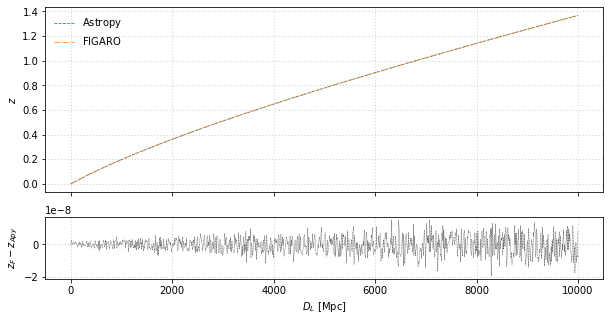

In [6]:
import matplotlib.pyplot as plt

fig, (ax,res) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex = True, figsize = (10,5))

ax.plot(DL, z_astropy, ls = '--', lw = 0.8, label = "$\mathrm{Astropy}$")
ax.plot(DL, z_figaro, ls = '-.', lw = 0.8, label = "$\mathrm{FIGARO}$")
ax.set_ylabel('$z$')
ax.grid(True,dashes=(1,3))
ax.legend(loc = 0, frameon= False)
res.plot(DL, z_figaro-z_astropy, ls = '--', color = 'k', lw = 0.3)
res.set_ylabel('$z_{F} - z_{Apy}$')
res.set_xlabel('$D_L\ [\mathrm{Mpc}]$')
res.grid(True,dashes=(1,3))